In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import time
import warnings

# ===============================
# Machine Learning & Model Tuning
# ===============================
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    mean_absolute_percentage_error
)
from sklearn.ensemble import RandomForestRegressor

# XGBoost (SOTA model cho dữ liệu bảng)
from xgboost import XGBRegressor

# ===============================
# Cấu hình chung
# ===============================
pd.set_option('display.float_format', lambda x: '%.4f' % x)
warnings.filterwarnings('ignore')

# Seed để kết quả ổn định (rất nên có)
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Đã import và cấu hình xong thư viện!")

Đã import và cấu hình xong thư viện!


In [13]:
# Load dữ liệu
import os

DATA_PATH = '../data/processed/clean_vn_housing.csv'

if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(
        "Không tìm thấy file dữ liệu. "
        "Hãy chắc chắn Thành viên 1 đã chạy xong bước data_cleaning."
    )

df = pd.read_csv(DATA_PATH)

print("Load dữ liệu thành công!")
print(f"Kích thước dữ liệu: {df.shape}")

# ===============================
# Kiểm tra nhanh dữ liệu
# ===============================
print("\nSố giá trị thiếu trên mỗi cột:")
print(df.isnull().sum())

print("\nKiểu dữ liệu các cột:")
print(df.dtypes)

# Xem trước dữ liệu
df.head()

Load dữ liệu thành công!
Kích thước dữ liệu: (81825, 9)

Số giá trị thiếu trên mỗi cột:
District               0
Ward                   0
House_type             0
Legal                  0
Floors                 0
Bedrooms               0
Area                   0
Price_per_m2           0
Total_Price_Billion    0
dtype: int64

Kiểu dữ liệu các cột:
District                 int64
Ward                     int64
House_type               int64
Legal                    int64
Floors                 float64
Bedrooms               float64
Area                   float64
Price_per_m2           float64
Total_Price_Billion    float64
dtype: object


,District,Ward,House_type,Legal,Floors,Bedrooms,Area,Price_per_m2,Total_Price_Billion
0,0,0,0,0,4.0000,5.0000,46.0000,86.9600,4.0002
1,1,1,1,1,5.0000,3.0000,37.0000,116.2200,4.3001
2,2,2,0,0,4.0000,4.0000,40.0000,65.0000,2.6000
3,3,3,0,0,5.0000,6.0000,51.0000,100.0000,5.1000
4,1,1,0,1,5.0000,4.0000,36.0000,86.1100,3.1000


In [14]:
# 1. Tách Feature (X) và Target (y)
target_col = 'Total_Price_Billion'

# Loại bỏ các cột không dùng để train
# Lưu ý: Phải bỏ 'Price_per_m2' vì gây Data Leakage
drop_cols = [target_col, 'Price_per_m2']
drop_cols = [c for c in drop_cols if c in df.columns]

X = df.drop(columns=drop_cols)

# ===============================
# LOG-TRANSFORM TARGET (RẤT QUAN TRỌNG)
# ===============================
y = np.log1p(df[target_col])

# ===============================
# Đảm bảo toàn bộ feature là numeric
# ===============================
X = X.select_dtypes(include=[np.number])

print(f"Số feature dùng để train: {X.shape[1]}")

# 2. Chia Train/Test (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

print(f"Số lượng mẫu Train: {X_train.shape[0]}")
print(f"Số lượng mẫu Test:  {X_test.shape[0]}")

Số feature dùng để train: 7
Số lượng mẫu Train: 65460
Số lượng mẫu Test:  16365


In [15]:
# ===============================
# Chiến lược Cross-Validation
# ===============================
# Với đồ án: cv=5 là đủ, tránh RepeatedKFold gây train rất lâu
cv = 5

# ===============================
# Hàm đánh giá kết quả (ĐÚNG SAU LOG)
# ===============================
def evaluate_model(model, X_test, y_test, name="Model"):
    start_time = time.time()
    y_pred_log = model.predict(X_test)
    inference_time = time.time() - start_time

    # Chuyển ngược log -> giá trị thật
    y_test_real = np.expm1(y_test)
    y_pred_real = np.expm1(y_pred_log)

    mae = mean_absolute_error(y_test_real, y_pred_real)
    rmse = np.sqrt(mean_squared_error(y_test_real, y_pred_real))
    r2 = r2_score(y_test_real, y_pred_real)
    mape = mean_absolute_percentage_error(y_test_real, y_pred_real)

    print(f"--- ĐÁNH GIÁ CHI TIẾT: {name} ---")
    print(f"MAE  (Sai số tuyệt đối): {mae:.4f} Tỷ VNĐ")
    print(f"RMSE (Sai số bình phương): {rmse:.4f} Tỷ VNĐ")
    print(f"MAPE (Sai số phần trăm): {mape:.2%} (Thấp là tốt)")
    print(f"R2 Score (Độ phù hợp): {r2:.4f} (Cao là tốt)")
    print(f"Thời gian dự đoán: {inference_time:.4f} giây")
    print("-" * 45)

    return {
        'Model': name,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'R2': r2
    }

results_list = []

In [16]:
print(">>> Bắt đầu Tuning Random Forest (Chế độ High-Performance)...")

# 1. Pipeline Random Forest
rf_pipeline = Pipeline([
    ('clf', RandomForestRegressor(
        random_state=RANDOM_STATE,
        n_jobs=-1 # Sử dụng toàn bộ 12 luồng CPU
    ))
])

# 2. Grid Search "MỞ KHÓA SỨC MẠNH"
# Tại sao lại chọn tham số này?
# - min_samples_leaf=1: Cho phép cây học đến từng chi tiết nhỏ nhất (code cũ để là 5 làm giảm độ chính xác).
# - max_depth=None: Không giới hạn độ sâu, để cây tự học đến khi tối ưu.
# - max_features=0.5: Mỗi lần tách nhánh nhìn 50% số cột (cân bằng tốt nhất giữa tốc độ và độ chính xác).

param_grid_rf_best = {
    'clf__n_estimators': [500],       # Số cây đủ lớn để ổn định
    'clf__max_depth': [30, None],     # Cho phép cây rất sâu hoặc không giới hạn
    'clf__min_samples_split': [2, 5], # Tách nhánh chi tiết
    'clf__min_samples_leaf': [1, 2],  # QUAN TRỌNG: Giảm xuống 1-2 để tăng độ chính xác (R2)
    'clf__max_features': ['sqrt', 0.5] # Thử nghiệm nhìn 50% dữ liệu
}

# 3. Grid Search
grid_rf = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=param_grid_rf_best,
    scoring='neg_mean_squared_error', # Tối ưu hóa sai số
    cv=3,       # CV=3 là đủ cho cấu hình nặng này
    n_jobs=-1,  # Full công suất CPU
    verbose=2
)

grid_rf.fit(X_train, y_train)

# 4. Kết quả
print("\nTham số tốt nhất (RF Best):", grid_rf.best_params_)
rf_metrics = evaluate_model(
    grid_rf.best_estimator_,
    X_test,
    y_test,
    "Random Forest (High Performance)"
)
results_list.append(rf_metrics)

>>> Bắt đầu Tuning Random Forest (Chế độ High-Performance)...
Fitting 3 folds for each of 16 candidates, totalling 48 fits

Tham số tốt nhất (RF Best): {'clf__max_depth': None, 'clf__max_features': 0.5, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 5, 'clf__n_estimators': 500}
--- ĐÁNH GIÁ CHI TIẾT: Random Forest (High Performance) ---
MAE  (Sai số tuyệt đối): 1.3008 Tỷ VNĐ
RMSE (Sai số bình phương): 3.3201 Tỷ VNĐ
MAPE (Sai số phần trăm): 24.53% (Thấp là tốt)
R2 Score (Độ phù hợp): 0.6084 (Cao là tốt)
Thời gian dự đoán: 0.2320 giây
---------------------------------------------


In [17]:
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

print(">>> Bắt đầu Tuning XGBoost (Chế độ GPU - Tối ưu RTX 3050)...")
print("Đang kích hoạt GPU... Bạn sẽ thấy tốc độ train cực nhanh.")

# 1. Pipeline XGBoost (Bản mới nhất)
# Lưu ý: Vì bạn đã Log Transform ở Cell 3, XGBoost sẽ học trên log(giá)
xgb_pipeline = Pipeline([
    ('clf', xgb.XGBRegressor(
        objective='reg:squarederror',
        # --- CẤU HÌNH GPU MỚI ---
        device='cuda',           # Dùng Card rời NVIDIA
        tree_method='hist',      # Thuật toán tối ưu nhất hiện nay
        # ------------------------
        random_state=42,
        n_jobs=-1
    ))
])

# 2. Grid Search Sâu & Chi tiết
# Chúng ta sẽ thử Learning Rate rất nhỏ để mô hình học kỹ từng chút một
param_grid_xgb_best = {
    # Số cây: Thử nhiều cây hơn vì GPU chạy rất nhanh
    'clf__n_estimators': [1000, 2000, 3000],

    # Tốc độ học: Quan trọng nhất. 0.01 thường cho kết quả tốt nhất.
    'clf__learning_rate': [0.01, 0.02, 0.05],

    # Độ sâu: XGBoost cần sâu hơn RF một chút để bắt các mẫu hình phức tạp
    'clf__max_depth': [6, 8, 10],

    # Regularization: Mỗi cây chỉ học 1 phần dữ liệu để tránh học vẹt
    'clf__subsample': [0.8, 0.9],
    'clf__colsample_bytree': [0.7, 0.9]
}

# 3. Chạy Grid Search
grid_xgb = GridSearchCV(
    estimator=xgb_pipeline,
    param_grid=param_grid_xgb_best,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1
)

grid_xgb.fit(X_train, y_train)

# 4. Kết quả
print("\nTham số tốt nhất (XGB GPU):", grid_xgb.best_params_)

# Đánh giá mô hình (Hàm evaluate_model của bạn đã có bước expm1 để chuyển log về giá thật)
xgb_metrics = evaluate_model(
    grid_xgb.best_estimator_,
    X_test,
    y_test,
    "XGBoost (Final GPU Optimized)"
)
results_list.append(xgb_metrics)

>>> Bắt đầu Tuning XGBoost (Chế độ GPU - Tối ưu RTX 3050)...
Đang kích hoạt GPU... Bạn sẽ thấy tốc độ train cực nhanh.
Fitting 3 folds for each of 108 candidates, totalling 324 fits

Tham số tốt nhất (XGB GPU): {'clf__colsample_bytree': 0.7, 'clf__learning_rate': 0.01, 'clf__max_depth': 8, 'clf__n_estimators': 2000, 'clf__subsample': 0.9}
--- ĐÁNH GIÁ CHI TIẾT: XGBoost (Final GPU Optimized) ---
MAE  (Sai số tuyệt đối): 1.2644 Tỷ VNĐ
RMSE (Sai số bình phương): 3.1599 Tỷ VNĐ
MAPE (Sai số phần trăm): 23.74% (Thấp là tốt)
R2 Score (Độ phù hợp): 0.6453 (Cao là tốt)
Thời gian dự đoán: 0.0802 giây
---------------------------------------------


=== TỔNG HỢP VÀ SO SÁNH KẾT QUẢ ===
                              Model    MAE   RMSE   MAPE     R2
0     XGBoost (Final GPU Optimized) 1.2644 3.1599 0.2374 0.6453
1  Random Forest (High Performance) 1.3008 3.3201 0.2453 0.6084

✅ Đã lưu bảng so sánh vào: ../reports/model_comparison.csv
✅ Đã lưu biểu đồ vào: ../reports/model_comparison.png


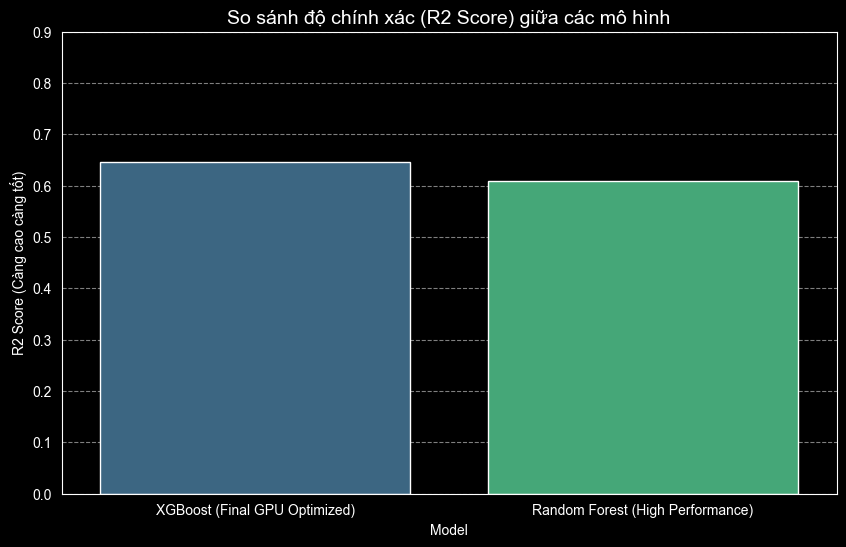


🏆 MÔ HÌNH VÔ ĐỊCH: XGBoost (Final GPU Optimized)
✅ Đã lưu model tốt nhất vào: ../models/house_price_model.pkl
>>> Sẵn sàng bàn giao cho Thành viên 5!


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib
import os

print("=== TỔNG HỢP VÀ SO SÁNH KẾT QUẢ ===")

# 1. Tạo bảng dữ liệu so sánh
# results_list chứa kết quả từ các cell trước
comparison_df = pd.DataFrame(results_list)

# Sắp xếp theo R2 giảm dần (Model tốt nhất lên đầu)
comparison_df = comparison_df.sort_values(by='R2', ascending=False).reset_index(drop=True)

print(comparison_df)

# 2. LƯU BẢNG SO SÁNH (Quan trọng cho báo cáo)
# Tạo thư mục reports nếu chưa có
if not os.path.exists('../reports'):
    os.makedirs('../reports')

comparison_df.to_csv('../reports/model_comparison.csv', index=False)
print("\n✅ Đã lưu bảng so sánh vào: ../reports/model_comparison.csv")

# 3. VẼ VÀ LƯU BIỂU ĐỒ (Quan trọng cho Slide)
plt.figure(figsize=(10, 6))
# Vẽ biểu đồ cột dựa trên R2
ax = sns.barplot(x='Model', y='R2', data=comparison_df, palette='viridis')

# Điền con số cụ thể lên đầu cột để dễ nhìn
for index, row in comparison_df.iterrows():
    ax.text(index, row.R2 + 0.01, f"{row.R2:.4f}", color='black', ha="center", fontweight='bold')

plt.title('So sánh độ chính xác (R2 Score) giữa các mô hình', fontsize=14)
plt.ylabel('R2 Score (Càng cao càng tốt)')
plt.ylim(0, 0.9) # Đặt giới hạn trục Y
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Lưu ảnh biểu đồ
plt.savefig('../reports/model_comparison.png', dpi=300) # dpi=300 để ảnh nét căng
print("✅ Đã lưu biểu đồ vào: ../reports/model_comparison.png")
plt.show()

# 4. CHỌN VÀ LƯU MODEL TỐT NHẤT (BEST MODEL)
# Lấy tên model đứng đầu bảng xếp hạng
best_model_name = comparison_df.iloc[0]['Model']
print(f"\n🏆 MÔ HÌNH VÔ ĐỊCH: {best_model_name}")

# Logic chọn object model để lưu
# Lưu ý: Biến grid_xgb và grid_rf phải tồn tại từ các cell trước
if 'XGBoost' in best_model_name:
    final_model = grid_xgb.best_estimator_
else:
    final_model = grid_rf.best_estimator_

# Lưu file .pkl cho App
if not os.path.exists('../models'):
    os.makedirs('../models')

save_path = '../models/house_price_model.pkl'
joblib.dump(final_model, save_path)
print(f"✅ Đã lưu model tốt nhất vào: {save_path}")
print(">>> Sẵn sàng bàn giao cho Thành viên 5!")